In [3]:
from trimesh import *
from swf import *
from optimal import *
from utils import *
import numpy as np
import soundfile as sf
from scipy import spatial
import matplotlib.pyplot as plt

import fileinput
import sys

def random_three_vector():
    """
    Generates a random 3D unit vector (direction) with a uniform spherical distribution
    Algo from http://stackoverflow.com/questions/5408276/python-uniform-spherical-distribution
    :return:
    """
    phi = np.random.uniform(0,np.pi*2)
    costheta = np.random.uniform(-1,1)

    theta = np.arccos( costheta )
    x = np.sin( theta) * np.cos( phi )
    y = np.sin( theta) * np.sin( phi )
    z = np.cos( theta )
    return (x,y,z)

In [4]:
layout704=np.array([[1,np.pi/6,np.pi/2],[1,-np.pi/6,np.pi/2],[1,0,np.pi/2],[1,np.pi/2,np.pi/2],[1,-np.pi/2,np.pi/2],[1,3*np.pi/4,np.pi/2],[1,-3*np.pi/4,np.pi/2],[1,np.pi/4,np.pi/4],[1,-np.pi/4,np.pi/4],[1,3*np.pi/4,np.pi/4],[1,-3*np.pi/4,np.pi/4]])
vertices704 = np.apply_along_axis(lambda x: toCartesian(x),1,layout704)
faces704 = np.array([[6,4,10],[10,4,8],[8,4,1],[8,1,2],[8,7,2],[7,2,0],[7,0,3],[7,3,9],[9,3,5],[10,7,9],[10,8,7],[10,6,5],[10,9,5]])

verticesOCT = np.array([[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,1],[0,0,-1]])
facesOCT = np.array([[1,2,4],[1,3,4],[3,0,4],[0,2,4],[1,3,5],[3,0,5],[0,2,5],[2,1,5]])

model = OptimalSWF(vertices704,faces704).model

In [29]:
data, samplerate = sf.read('bossa.wav')
data = np.hstack((data,data))
#data = np.ones(data.shape) #to see gains
vertexTree = spatial.KDTree(model.meshes[-1].vertices)

triangles = model.meshes[-1].vertices[model.meshes[-1].faces] #get each face as a coordinaes in R3

centroids = triangles.mean(axis=1)

centroidsTree = spatial.KDTree(centroids)

In [6]:
'''
#Compute encoding for immobile point source 
fine = np.zeros((model.meshes[-1].vertices.shape[0],data.shape[0]))
loc = vertexTree.query([random_three_vector()])[1][0]
onehot = np.zeros((model.meshes[-1].vertices.shape[0],1))
onehot[:11] = -1
onehot[loc]=1
fine[loc] = data
coarse = model.encode(fine)
coarse = np.insert(coarse, 3, 0, axis=0) #add empty subwoofer channel for reproduction in the studio

#weights3D(model.meshes[-1],onehot,'point source location') #graph it

sf.write('pointSource.wav',coarse.T,samplerate)
'''

"\n#Compute encoding for immobile point source \nfine = np.zeros((model.meshes[-1].vertices.shape[0],data.shape[0]))\nloc = vertexTree.query([random_three_vector()])[1][0]\nonehot = np.zeros((model.meshes[-1].vertices.shape[0],1))\nonehot[:11] = -1\nonehot[loc]=1\nfine[loc] = data\ncoarse = model.encode(fine)\ncoarse = np.insert(coarse, 3, 0, axis=0) #add empty subwoofer channel for reproduction in the studio\n\n#weights3D(model.meshes[-1],onehot,'point source location') #graph it\n\nsf.write('pointSource.wav',coarse.T,samplerate)\n"

In [7]:
#Compute a Horizontal Panning
fine = np.zeros((model.meshes[-1].vertices.shape[0],data.shape[0])) #empty multichannel array to eventually fill
theta = np.linspace(0,2*np.pi,data.shape[0])
x = np.cos(theta) #x component of the circular panning 
y = np.sin(theta) #y component of the circular panning 

horizontalPanning = np.vstack((x,y,np.zeros(theta.shape[0]))).T #the circle in R3 w/ z=0

#dist, ind = vertexTree.query(horizontalPanning, k=3) #3 nearest neighbors to query point, distances and indices
#dist, ind = centroidsTree.query(horizontalPanning,k=1) #nearest face centroid to query point, distances and indices
closest, dist, ind = model.meshes[-1].closest_point_naive(horizontalPanning)

Text(0.5, 1.0, 'Zero-Centered Distance of closest neighbor')

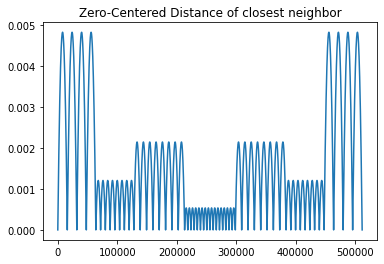

In [8]:
plt.plot(np.fft.fftshift(dist))
plt.title('Zero-Centered Distance of closest neighbor')

In [25]:
def AreaTRI(TRI):
    TR = TRI[:,1] - TRI[:,0] #get the TR vector of the triangle TRI
    TI = TRI[:,2] - TRI[:,0] #get the TI vector of the triangle TRI
    return np.linalg.norm(np.cross(TR,TI),axis=1)/2 #Area of the triangle TRI

PQR = triangles[ind] 
#PQR = model.meshes[-1].vertices[ind] #get vertex locations in R3 for the 3 nearest neighbors P,Q,R
AreaPQR = AreaTRI(PQR) #Area of PQR

PQ = PQR[:,1] - PQR[:,0] #get the PQ vector of the triangle PQR
PR = PQR[:,2] - PQR[:,0] #get the PR vector of the triangle PQR
normals = np.cross(PQ,PR) #get the normal vector for the plane defined by the triangle PQR
unitNormals = normals/np.linalg.norm(normals,axis=1).reshape(-1,1) #normal vector of unit length defined by PQR
d = -1 * np.sum(PQR[:,0,:]*unitNormals,axis=1)
scalarDist = np.sum(unitNormals*(horizontalPanning-PQR[:,0,:]),axis=1) #scalar distance from panning point to plane along the normal

projection = horizontalPanning - scalarDist.reshape(-1,1)*unitNormals #projection of panning point onto the plane defined by triangle PQR

#projection = horizontalPanning - (unitNormals ⋅ (horizontalPanning - P)) * unitNormals

S = projection.reshape(-1,1,3) #reshaped for use in the area calculations

SQR = np.hstack((S,PQR[:,1:,:])) #The triangle SQR defined by the panning point S and its two furthest neighbors
PSR = np.hstack((PQR[:,0,:].reshape(-1,1,3),S,PQR[:,2,:].reshape(-1,1,3))) #The triangle PSR defined by S and its closest and furthest neighbors
PQS = np.hstack((PQR[:,:2,:],S)) #The triangle PQS defined by S and its two closest neighbors

AreaSQR = AreaTRI(SQR) #area of SQR
AreaPSR = AreaTRI(PSR) #area of PSR
AreaPQS = AreaTRI(PQS) #area of PQS

interpolation = np.vstack((AreaSQR/AreaPQR,AreaPSR/AreaPQR,AreaPQS/AreaPQR)).T 
#interpolation = interpolation/interpolation.sum(axis=1).reshape(-1,1)

Text(0.5, 1.0, 'Zero-Centered interpolation sum')

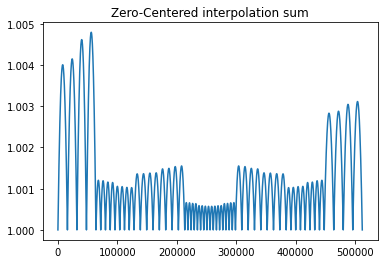

In [26]:
plt.plot(np.fft.fftshift(interpolation.sum(axis=1)))
plt.title('Zero-Centered interpolation sum')

In [17]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame(np.vstack((PQR[311999],horizontalPanning[311999])),columns=['x','y','z'])
df['point'] = [0,0,0,1]

fig = px.scatter_3d(df, x='x',y='y',z='z',color='point')
fig.show()

In [10]:
#simple interpolation
#interpolation = dist/dist.sum(axis=1).reshape(-1,1)

In [30]:
for i in range(data.shape[0]):
    fine[model.meshes[-1].faces[ind[i]],i] = data[i]*interpolation[i] #### THIS LINE MUST BE CHANGED FOR CENTROID-BASED APPROACH ####
coarse = model.encode(fine)
coarse = np.insert(coarse, 3, 0, axis=0) #add empty subwoofer channel for reproduction in the studio

sf.write('horizontalPanUnnormalized.wav',coarse.T,samplerate)

In [ ]:
#save encoder and vertex arrays for use in Max MSP
encoder = model.phi2s[0]
np.savetxt('encoder.txt',encoder,newline=';\n')
for line in fileinput.input('encoder.txt',inplace=True):
    sys.stdout.write('%d, %s'%(fileinput.filelineno(), line))
np.savetxt('vertices.txt',model.meshes[-1].vertices,newline=';\n')
for line in fileinput.input('vertices.txt',inplace=True):
    sys.stdout.write('%d, %s'%(fileinput.filelineno(), line))